In [2]:
import importlib
import time_series_dataloader
importlib.reload(time_series_dataloader)
from time_series_dataloader import TimeSeriesDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from models.loss import SinkhornDistance

import chronos_forecasting.run_chronos
import importlib
importlib.reload(chronos_forecasting.run_chronos)

from chronos_forecasting.run_chronos import ChronosRunner


In [5]:
stock_data = TimeSeriesDataset(r"datasets\separated_company_size_same_length\Retail", "Open")
layoff_data = TimeSeriesDataset(r"datasets\separated_company_size_same_length\Retail", "company_size")

In [6]:
stock_data_loader = DataLoader(dataset=stock_data, batch_size=1, 
                                shuffle=False, drop_last=False, num_workers=0)

layoff_data_loader = DataLoader(dataset=layoff_data, batch_size=1, 
                                shuffle=False, drop_last=False, num_workers=0)

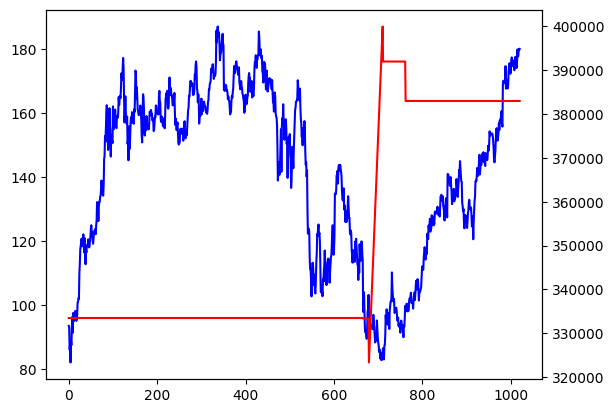

In [7]:
src_x = stock_data_loader.dataset[0][0]
trg_x = layoff_data_loader.dataset[0][0]
fig, ax1 = plt.subplots()
ax1.plot(src_x, label="src: Stock Prices", color="blue")
ax2  = ax1.twinx()
ax2.plot(trg_x, label="trg: Total Layoffs", color="red")

C:\Users\msuehle\AppData\Local\Temp\ipykernel_21736\1864758440.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_x = torch.tensor(src_x)
C:\Users\msuehle\AppData\Local\Temp\ipykernel_21736\1864758440.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trg_x = torch.tensor(trg_x)


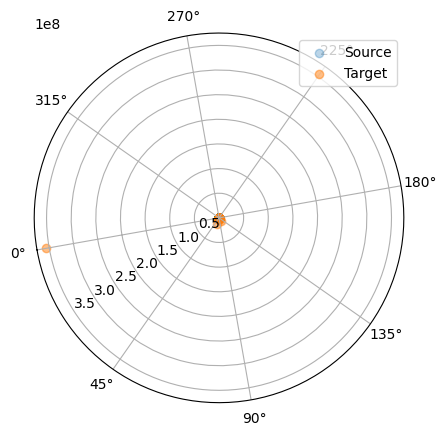

In [8]:
src_x = torch.tensor(src_x)
trg_x = torch.tensor(trg_x)

# Extract frequency features for the source domain
x_ft_src = torch.fft.rfft(src_x)
r_src = x_ft_src.abs()
p_src = x_ft_src.angle() 
# Extract frequency features for the target domain
x_ft_trg = torch.fft.rfft(trg_x)
r_trg = x_ft_trg.abs()
p_trg = x_ft_trg.angle() 

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(p_src, r_src, alpha=0.3, label='Source')
c = ax.scatter(p_trg, r_trg, alpha=0.5, label='Target')


ax.set_theta_zero_location('W', offset=10)
ax.legend(loc='best')

In [9]:
# Frequency Feature Extractor
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, fl=128):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x = torch.cos(x)
        x_ft = torch.fft.rfft(x,norm='ortho')
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        # print(x_ft)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1) 
        r = out_ft[:, :, :self.modes1].abs()
        p = out_ft[:, :, :self.modes1].angle() 
        return torch.concat([r,p],-1), out_ft

In [10]:
# Time Feature Extractor
class CNN(nn.Module):
    def __init__(self, configs):
        super(CNN, self).__init__()
        self.width = configs.input_channels
        self.channel = configs.input_channels
        self.fl =   configs.sequence_len
        self.fc0 = nn.Linear(self.channel, self.width) # input channel is 2: (a(x), x)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(configs.input_channels, configs.mid_channels, kernel_size=configs.kernel_size,
                      stride=configs.stride, bias=False, padding=(configs.kernel_size // 2)),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(configs.dropout)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv1d(configs.mid_channels, configs.mid_channels , kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(configs.mid_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv1d(configs.mid_channels , configs.final_out_channels, kernel_size=8, stride=1, bias=False,
                      padding=4),
            nn.BatchNorm1d(configs.final_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(configs.features_len)

        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block3(x)
        x = self.adaptive_pool(x)
        x_flat = x.reshape(x.shape[0], -1)
        return x_flat

In [11]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain adaptation algorithm.
    Subclasses should implement the update() method.
    """

    def __init__(self, configs):
        super(Algorithm, self).__init__()
        self.configs = configs
        self.loss = nn.MSELoss()
        
    def update(self, *args, **kwargs):
        raise NotImplementedError


In [12]:
class tf_encoder(nn.Module):
    def __init__(self, configs):
        super(tf_encoder, self).__init__()
        self.modes1 = configs.fourier_modes   # Number of low-frequency modes to keep
        self.width = configs.input_channels
        self.length =  configs.sequence_len
        self.freq_feature = SpectralConv1d(self.width, self.width, self.modes1,self.length)  # Frequency Feature Encoder
        self.bn_freq = nn.BatchNorm1d(configs.fourier_modes*2)   # It doubles because frequency features contain both amplitude and phase
        self.cnn = CNN(configs).to('cuda')  # Time Feature Encoder
        self.avg = nn.Conv1d(self.width, 1, kernel_size=3 ,
                  stride=configs.stride, bias=False, padding=(3 // 2))   


    def forward(self, x):
        ef, out_ft = self.freq_feature(x)
        ef = F.relu(self.bn_freq(self.avg(ef).squeeze()))
        et = self.cnn(x)
        f = torch.concat([ef,et],-1)
        return F.normalize(f), out_ft

class tf_decoder(nn.Module):
    def __init__(self, configs):
        super(tf_decoder, self).__init__()
        self.input_channels, self.sequence_len = configs.input_channels, configs.sequence_len
        self.bn1 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.bn2 = nn.BatchNorm1d(self.input_channels,self.sequence_len)
        self.convT = torch.nn.ConvTranspose1d(configs.final_out_channels, self.sequence_len, self.input_channels, stride=1)
        self.modes = configs.fourier_modes

    def forward(self, f, out_ft):
        x_low = self.bn1(torch.fft.irfft(out_ft, n=self.sequence_len))   # reconstruct  time series by using low frequency frequency features
        et = f[:,self.modes*2:]
        x_high = F.relu(self.bn2(self.convT(et.unsqueeze(2)).permute(0,2,1))) # reconstruct time series by using time features for high frequency patterns. 
        return x_low + x_high

In [13]:
class RAINCOAT(Algorithm):
    def __init__(self, configs, hparams, device):
        super(RAINCOAT, self).__init__(configs)
        self.feature_extractor = tf_encoder(configs).to(device)
        self.decoder = tf_decoder(configs).to(device)
        self.cr = ChronosRunner()
        
        self.optimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters()) + \
                list(self.decoder.parameters()),
            lr=hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
        self.coptimizer = torch.optim.Adam(
            list(self.feature_extractor.parameters())+list(self.decoder.parameters()),
            lr=1*hparams["learning_rate"],
            weight_decay=hparams["weight_decay"]
        )
            
        self.hparams = hparams
        self.recons = nn.L1Loss(reduction='sum').to(device)
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.sink = SinkhornDistance(eps=1e-3, max_iter=1000, reduction='sum')
        self.device = device    
    
    def update(self, src_x, trg_x):
  
        self.optimizer.zero_grad()
        # Encode both source and target features via our time-frequency feature encoder
        src_feat, out_s = self.feature_extractor(src_x)   
        trg_feat, out_t = self.feature_extractor(trg_x)
        # Decode extracted features to time series
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        # Compute reconstruction loss 
        recons = 1e-4 * (self.recons(src_recon, src_x) + self.recons(trg_recon, trg_x))
        recons.backward(retain_graph=True)
        # Compute alignment loss
        dr, _, _ = self.sink(src_feat, trg_feat)
        sink_loss = dr
        sink_loss.backward(retain_graph=True)
        # Compute classification loss
        results = self.cr.evaluate(src_recon.to('cpu'), trg_x.to('cpu'))
        loss_cls = self.loss(results["median"].double(), results['labels'].double()) 
        loss_cls.backward(retain_graph=True)
        self.optimizer.step()
        return {'Src_cls_loss': loss_cls.item(),'Sink': sink_loss.item()}
    
    def correct(self, src_x, trg_x):
        self.coptimizer.zero_grad()
        src_feat, out_s = self.feature_extractor(src_x)
        trg_feat, out_t = self.feature_extractor(trg_x)
        src_recon = self.decoder(src_feat, out_s)
        trg_recon = self.decoder(trg_feat, out_t)
        recons = 1e-4 * (self.recons(trg_recon, trg_x) + self.recons(src_recon, src_x))
        recons.backward()
        self.coptimizer.step()
        return {'recon': recons.item()}

In [14]:
def eval(algorithm, loader_src, loader_trg, final=False, make_plot=False):
    device = 'cuda'
    feature_extractor = algorithm.feature_extractor.to(device)
    decoder = algorithm.decoder.to(device)
    cr = ChronosRunner()
    if final == True:
        feature_extractor.load_state_dict(torch.load('backbone.pth'))
        decoder.load_state_dict(torch.load("decoder.pth"))
    feature_extractor.eval()

    llosses = []
    mlosses = []
    hlosses = []

    with torch.no_grad():
        joint_loaders = enumerate(zip(loader_src, loader_trg))
        for step, (src_x, trg_x) in joint_loaders:
            src_x, trg_x = src_x.float().to(device), trg_x.float().to(device)
            
            features, out_f = feature_extractor(src_x)
            decoded_x = decoder(features, out_f)
            results = cr.evaluate(decoded_x.to('cpu'), trg_x.to('cpu'), make_plot=make_plot)
            llosses.append(results['lloss'])
            mlosses.append(results['mloss'])
            hlosses.append(results['hloss'])

    return dict(
        lloss = np.array(llosses).mean(),
        mloss = np.array(mlosses).mean(),
        hloss = np.array(hlosses).mean()
    )

In [17]:
class data_config():
    def __init__(self):
        # super(WISDM_config, self)
        # self.class_names = ['walk', 'jog', 'sit', 'stand', 'upstairs', 'downstairs']
        self.sequence_len = 1021 #1034
        # Transfer scenarios, e.g., from source domain 2 to target domain 32
        # self.scenarios = [("2", "32"), ("4", "15"),("7", "30"),('12','7'), ('12','19'),('18','20'),\
                        #   ('20','30'), ("21", "31"),("25", "29"), ('26','2')]

        # self.num_classes = 6
        self.shuffle = True
        self.drop_last = False
        self.normalize = True

        # model configs
        self.input_channels = 1
        self.kernel_size = 5
        self.stride = 1
        self.dropout = 0.5
        self.num_classes = 6
        self.width = 64  
        # for Fourier Frequency Feature Extration, number of modes to keep 
        self.fourier_modes = 64  
        # features
        self.mid_channels = 64
        self.final_out_channels = 128
        self.out_dim = self.final_out_channels+ self.fourier_modes * 2
        self.features_len = 1

<h4> Training </h4>

In [21]:
import math
device = 'cuda'
dataset_configs = data_config()
hparams = {"batch_size":64, 'learning_rate':1e-3,'weight_decay': 1e-4,'num_epochs': 100}

algorithm = RAINCOAT(dataset_configs, hparams,device)
algorithm.to(device)
best_mse = math.inf
train_industries = ["Retail", "Food", "Healthcare"]
valid_industry = 'Travel'
test_industry = "HR"
src_col = "Open"
trg_col = "company_size"

### Alignment
for i in range(hparams['num_epochs']):
    curr_mse = math.inf
    for industry in train_industries:
        src_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{industry}", src_col)
        src_train_dl = DataLoader(dataset=src_data, batch_size=2, 
                                 shuffle=False, drop_last=True, num_workers=0)
        trg_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{industry}", trg_col)
        trg_train_dl = DataLoader(dataset=trg_data, batch_size=2,
                                  shuffle=False, drop_last=True, num_workers=0)    
        joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
        for step, (src_x, trg_x) in joint_loaders:
            src_x, trg_x = src_x.float().to(device), trg_x.float().to(device)
            loss = algorithm.update(src_x, trg_x)

        results = eval(algorithm, src_train_dl, trg_train_dl)
        curr_mse = results['mloss']
    if curr_mse<=best_mse:
        best_mse = curr_mse
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.decoder.state_dict(), 'decoder.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation MSE on Source Test is {results["mloss"]}')

src_valid_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{valid_industry}", src_col)
src_valid_dl = DataLoader(dataset=src_valid_data, batch_size=2, 
                          shuffle=False, drop_last=True, num_workers=0)

trg_valid_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{valid_industry}", trg_col)
trg_valid_dl = DataLoader(dataset=trg_valid_data, batch_size=2, 
                          shuffle=False, drop_last=True, num_workers=0)

results = eval(algorithm, src_valid_dl, trg_valid_dl,final=True, make_plot=True)
print(f'MSE before correction: {results["mloss"]}')

### Correction 
for i in range(10):
    curr_mse = math.inf
    for industry in train_industries:
        src_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{industry}", src_col)
        src_train_dl = DataLoader(dataset=src_data, batch_size=2, 
                                 shuffle=False, drop_last=True, num_workers=0)
        trg_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{industry}", trg_col)
        trg_train_dl = DataLoader(dataset=trg_data, batch_size=2,
                                  shuffle=False, drop_last=True, num_workers=0)    
        joint_loaders = enumerate(zip(src_train_dl, trg_train_dl))
        for step, (src_x, trg_x) in joint_loaders:
            src_x, trg_x = src_x.float().to(device), trg_x.float().to(device)
            loss = algorithm.correct(src_x, trg_x)

        results = eval(algorithm, src_train_dl, trg_train_dl)
        curr_mse = results['mloss']

    if curr_mse<=best_mse:
        best_mse = curr_mse
        torch.save(algorithm.feature_extractor.state_dict(), 'backbone.pth')
        torch.save(algorithm.decoder.state_dict(), 'decoder.pth')
    if i %10==0:
        print(f'Epoch {i}: Validation MSE on Source Test is {results["mloss"]}')

src_valid_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{valid_industry}", src_col)
src_valid_dl = DataLoader(dataset=src_valid_data, batch_size=2, 
                          shuffle=False, drop_last=True, num_workers=0)

trg_valid_data = TimeSeriesDataset(f"datasets\\separated_company_size_same_length\\{valid_industry}", trg_col)
trg_valid_dl = DataLoader(dataset=trg_valid_data, batch_size=2, 
                          shuffle=False, drop_last=True, num_workers=0)

results = eval(algorithm, src_valid_dl, trg_valid_dl,final=True, make_plot=True)
print(f'MSE after correction: {results["mloss"]}')

c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 0: Validation MSE on Source Test is 12545655.122883866
Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Retail


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Food


c:\Users\msuehle\Documents\College\CMSC828A\CMSC828A_Final_Proj\env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Healthcare
